<a href="https://colab.research.google.com/github/young-hwanlee/stand_alone_deep_learning/blob/main/%2318_Lab_Handling_Visualization_of_Many_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

data  results  sample_data


In [2]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [3]:
!ls

data  results  sample_data


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy   # Add Deepcopy for args

## Data Preparation

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


## Model Architecture

In [6]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ===== Create Linear Layers ===== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ===== Create Activation Function ===== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ===== Create Regularization Layer ===== #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True)    # Testing Model Construction

## Train, Validate, Test and Experiment

In [7]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()   # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [8]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [9]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [10]:
def experiment(partition, args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ===== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ============================= #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ===== Add Epoch Data ===== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ======================= #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ===== Add Result to Dictionary ===== #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc

    # args: setting values
    # vars(args) -> make it into dict
    return vars(args), result
    # ============================= #

# Manage Experiment Result

In [11]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']                    # to avoid saving files depending on epoch
    del setting['test_batch_size']     # to avoid saving files depending on test batch size (which does not affect the results)

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)                # to merge dict and dict
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result)  # .drop(columns=[])
    return df
    

## Experiment

In [12]:
# ===== Random Seed Initialization ===== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ===== Model Capacity ===== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ===== Regularization ===== #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ===== Optimizer & Training ===== #
args.optim = 'RMSprop'  #SGD, RMSprop, ADAM, ...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ===== Experiment Variable ===== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [300, 500]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)      # args.name_var1 = var1
        setattr(args, name_var2, var2)      # args.name_var2 = var2
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)


Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=300, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 38.59/39.58, Loss(train/val) 2.18/1.75. Took 17.40 sec
Epoch 1, Acc(train/val): 46.48/41.66, Loss(train/val) 1.54/1.73. Took 14.46 sec
Epoch 2, Acc(train/val): 49.13/36.65, Loss(train/val) 1.47/2.03. Took 9.08 sec
Epoch 3, Acc(train/val): 52.05/44.14, Loss(train/val) 1.40/1.67. Took 9.07 sec
Epoch 4, Acc(train/val): 53.58/43.32, Loss(train/val) 1.35/1.68. Took 9.15 sec
Epoch 5, Acc(train/val): 55.23/40.67, Loss(train/val) 1.31/1.89. Took 9.23 sec
Epoch 6, Acc(train/val): 57.20/42.26, Loss(train/val) 1.25/2.04. Took 9.09 sec
Epoch 7, Acc(train/val): 58.90/47.80, Loss(train/val) 1.21/1.60. Took 9.07 sec
Epoch 8, Acc(train/val): 60.03/46.00, Loss(train/val) 1.17/1.84. Took 9.10 sec
Epoch 9, Acc(train/val): 61.51/44.85, Loss(train

In [13]:
!ls results

exp1_n_layer_hid_dim-41b634.json  exp1_n_layer_hid_dim-bfc899.json
exp1_n_layer_hid_dim-61a2d0.json  exp1_n_layer_hid_dim-cab8c1.json
exp1_n_layer_hid_dim-7b70fe.json  exp1_n_layer_hid_dim-dece45.json


In [14]:
!cat results/exp1_n_layer_hid_dim-41b634.json

{"train_losses": [1.7737114019454665, 1.5136946546044319, 1.409586350629284, 1.3280242347413567, 1.257904086143348, 1.2024329095889048, 1.151000559709634, 1.0944596661883554, 1.0423309913106784, 0.9936481566186164], "val_losses": [1.664892327785492, 1.5769919514656068, 1.458910918235779, 1.4894296646118164, 1.3600859642028809, 1.671690046787262, 1.4337029218673707, 1.5737257599830627, 1.4497947096824646, 1.4154622197151183], "train_accs": [36.7925, 45.74, 49.3325, 52.71, 55.2025, 57.0375, 58.995, 61.085, 62.7425, 64.7675], "val_accs": [41.51, 43.83, 48.38, 46.29, 51.61, 44.48, 50.72, 47.72, 50.82, 52.47], "train_acc": 64.7675, "val_acc": 52.47, "test_acc": 52.13, "exp_name": "exp1_n_layer_hid_dim", "in_dim": 3072, "out_dim": 10, "hid_dim": 300, "act": "relu", "dropout": 0.2, "use_bn": true, "l2": 1e-05, "use_xavier": true, "optim": "RMSprop", "lr": 0.0015, "train_batch_size": 256, "n_layer": 3}

In [15]:
df = load_exp_result('exp1')
print(df)

                                        train_losses  \
0  [2.18197802829135, 1.5422968127924925, 1.47143...   
1  [2.5221808359121822, 1.5707579653733854, 1.497...   
2  [1.763449923248048, 1.5175018432034049, 1.4147...   
3  [1.7945117540420241, 1.5204008794893884, 1.412...   
4  [1.7737114019454665, 1.5136946546044319, 1.409...   
5  [1.8357554939901752, 1.5184631712117773, 1.407...   

                                          val_losses  \
0  [1.7476146221160889, 1.7252756834030152, 2.032...   
1  [1.842672312259674, 1.818816351890564, 1.87070...   
2  [1.6531088709831239, 1.7597294449806213, 1.562...   
3  [1.6716274619102478, 1.691839349269867, 1.4884...   
4  [1.664892327785492, 1.5769919514656068, 1.4589...   
5  [1.7462174773216248, 1.9524584412574768, 1.612...   

                                          train_accs  \
0  [38.585, 46.48, 49.13, 52.05, 53.58, 55.23, 57...   
1  [37.705, 45.9025, 48.49, 50.625, 52.9575, 54.4...   
2  [37.1875, 46.2075, 50.0475, 52.3375, 54.922

In [16]:
load_exp_result('exp1').head()

,train_losses,val_losses,train_accs,val_accs,train_acc,val_acc,test_acc,exp_name,in_dim,out_dim,hid_dim,act,dropout,use_bn,l2,use_xavier,optim,lr,train_batch_size,n_layer
0,"[2.18197802829135, 1.5422968127924925, 1.47143...","[1.7476146221160889, 1.7252756834030152, 2.032...","[38.585, 46.48, 49.13, 52.05, 53.58, 55.23, 57...","[39.58, 41.66, 36.65, 44.14, 43.32, 40.67, 42....",61.5050,44.85,44.50,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,1
1,"[2.5221808359121822, 1.5707579653733854, 1.497...","[1.842672312259674, 1.818816351890564, 1.87070...","[37.705, 45.9025, 48.49, 50.625, 52.9575, 54.4...","[38.16, 41.04, 38.99, 44.49, 40.62, 42.3, 45.9...",61.2375,45.25,45.14,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,1
2,"[1.763449923248048, 1.5175018432034049, 1.4147...","[1.6531088709831239, 1.7597294449806213, 1.562...","[37.1875, 46.2075, 50.0475, 52.3375, 54.9225, ...","[41.68, 41.05, 45.06, 46.33, 46.27, 47.09, 49....",64.4400,52.16,51.44,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,2
3,"[1.7945117540420241, 1.5204008794893884, 1.412...","[1.6716274619102478, 1.691839349269867, 1.4884...","[37.0225, 46.15, 50.0525, 52.775, 55.18, 57.84...","[40.04, 42.59, 47.35, 47.18, 47.29, 41.12, 45....",66.4150,50.00,50.26,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,2
4,"[1.7737114019454665, 1.5136946546044319, 1.409...","[1.664892327785492, 1.5769919514656068, 1.4589...","[36.7925, 45.74, 49.3325, 52.71, 55.2025, 57.0...","[41.51, 43.83, 48.38, 46.29, 51.61, 44.48, 50....",64.7675,52.47,52.13,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,3


In [17]:
print(type(load_exp_result('exp1')))

<class 'pandas.core.frame.DataFrame'>


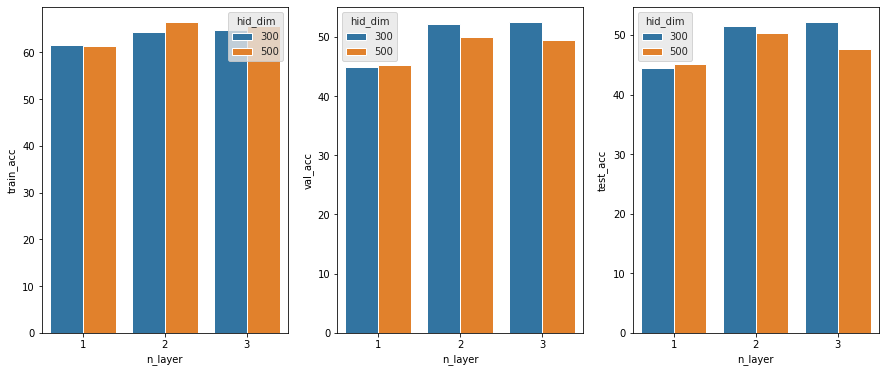

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='n_layer', y='train_acc', hue='hid_dim', data=df, ax=ax[0])
sns.barplot(x='n_layer', y='val_acc', hue='hid_dim', data=df, ax=ax[1])
sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=df, ax=ax[2])

In [19]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
print(list_v1, list_v2)

[1 2 3] [300 500]


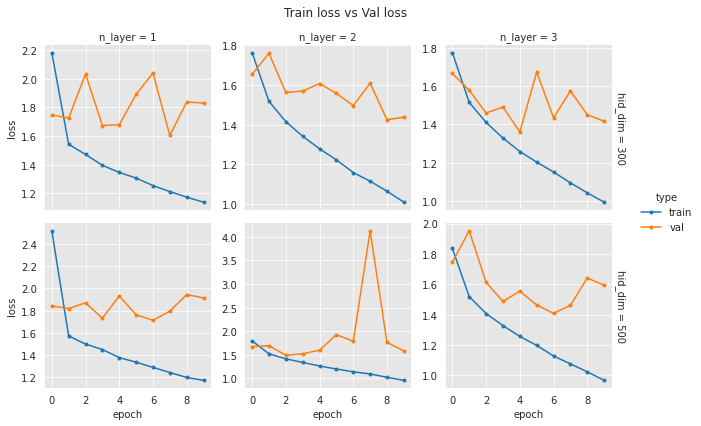

In [20]:
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]

        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

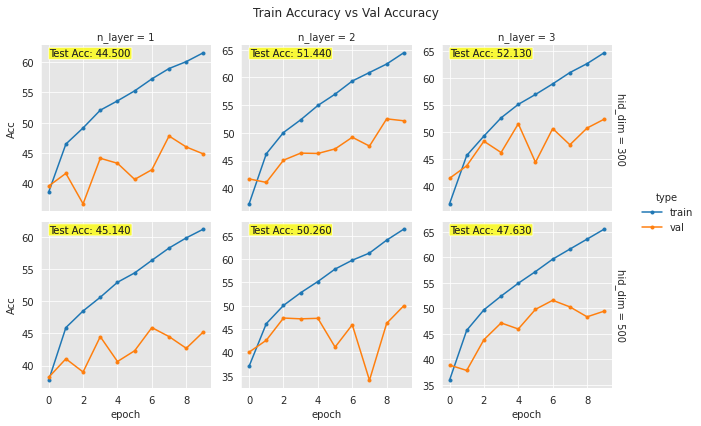

In [21]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')
plt.subplots_adjust(top=0.89)